## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote, unquote
from datetime import timedelta
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed 
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'wind_elec_gen'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get_tag_names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['h_6hrain',
 'h_6hsnow',
 'h_humidity',
 'h_rainprobability',
 'h_raintype',
 'h_seawave',
 'h_skystatus',
 'h_temperature',
 'h_winddirection',
 'h_windspeed',
 'hk1_1',
 'hk1_2',
 'hk1_3',
 'hk2_1',
 'hk2_2',
 'hk2_3',
 'hk2_4',
 'hk2_5',
 's_6hrain',
 's_6hsnow',
 's_humidity',
 's_rainprobability',
 's_raintype',
 's_seawave',
 's_skystatus',
 's_temperature',
 's_winddirection',
 's_windspeed',
 'ss_1',
 'ss_10',
 'ss_2',
 'ss_3',
 'ss_4',
 'ss_5',
 'ss_6',
 'ss_7',
 'ss_8',
 'ss_9']

## Converting TAG Name Format
* After checking all the Tag Names from the Wind Elec Gen dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use tag names related to the Hankyung Power Plant No. 1

In [5]:
# Set the desired tag names
tags = name[:13]

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'h_6hrain','h_6hsnow','h_humidity','h_rainprobability','h_raintype','h_seawave','h_skystatus','h_temperature','h_winddirection','h_windspeed','hk1_1','hk1_2','hk1_3'


## Load Wind Electric Generation Dataset
* Load the data using tag names related to the Hankyung Power Plant No. 1

In [6]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])

    # Set time index
    df.set_index('TIME', inplace=True)

    # Resample at 3-hour intervals
    df = df.resample('3H').mean()

    # Remove missing values
    df = df.dropna()

    # Merge power generation
    # Sum the power generation from Hankyung Power Plant 1, 2, and 3
    df.loc[:, 'hk1_total'] = df.iloc[:, 10:].sum(axis=1)

    return df

In [7]:
# Data time loading function
def time_data_load(table, name, start_time, end_time, timeformat):
    
    # Load the data 
    df = data_load(table, name, start_time, end_time, timeformat)
    
    # Calculate the maximum and minimum values of hk1_total
    max = df.iloc[:, -1:].max()
    min = df.iloc[:, -1:].min()
    
    # Keep only the time index
    df = df.iloc[:,:0]
    
    return df, min, max

In [8]:
# Time update function
# Update start and end times based on batch size
# window_size: The period over which data is collected in batches
# step_size: The interval between the data points
def update_time(time_df, start_time, batch_size, window_size, step_size):
    
    # Calculate how many data points need to be loaded
    time = (batch_size * step_size)+ window_size - step_size - 1
    
    # Check the index number of the current time
    # If not found, set to the first index as there is no data for the current time
    try:
        index_now = time_df.index.get_loc(start_time)
    except KeyError:
        index_now = 0
    
    # Set the end time for the batch data based on the current time
    end_time_ = str(time_df.index[index_now + time] + timedelta(hours=1))
    
    # Set the index number for the next start time
    index_next = index_now + time - abs(window_size - step_size - 1)
    
    # Set the next start time
    next_start_time_ = str(time_df.index[index_next])
    
    # URL encoding
    start_time_ = quote(start_time)
    end_time_ = quote(end_time_)
    next_start_time_ = quote(next_start_time_)
    
    return start_time_, end_time_, next_start_time_, index_next

In [9]:
# Function to calculate the maximum and minimum values for selected tag names
def set_minmax_value(table, name, start_time_train, end_time_train):
    
    # URL encoding
    start = quote(start_time_train)
    end = quote(end_time_train)
    
    # Load Min, Max data
    df_ = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-scale.tql?table={table}&name={name}&start={start}&end={end}')
    
    # Set Min, Max values
    Min = df_.iloc[:,1:-1].T
    Max = df_.iloc[:,2:].T
    
    return Min, Max 

## Data Preprocessing
   * 1 Window sliding
   * 2 MinMaxScaler

### 1. Window sliding setup
* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [10]:
# Sliding window function
def make_window(data, window_size, step_size):
    
    # List to store sliding window results
    windows = []
    targets = []
    
    # Apply sliding window
    for i in range(0, data.shape[0] - window_size + 1, step_size):
        
        window = data.iloc[i:i + window_size, :-1].values  # Exclude the last column
        target_array = data.iloc[i:i + window_size, -1].values  # The last column is the target
            
        windows.append(window)
        targets.append(target_array)

    return windows, targets

### 2. Min-Max Scaling Setup
* Set up a Min-Max Scaler that uses the maximum and minimum values, as the entire dataset is not loaded due to the process concept.

In [11]:
# Definition of the MinMaxScaler class
class MinMaxScaler_custom:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    # Set scale values based on the specified parameters
    def transform(self, X, min_values, max_values):
        X = np.array(X)
        self.min_ = np.array(min_values)
        self.max_ = np.array(max_values)
        
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        # Add 1e-6 to prevent the scale value from becoming 0
        scale = (self.max_ - self.min_) + 1e-6
        if np.any(scale == 0):
            raise ValueError("Min and Max values are the same, resulting in a scale of 0.")
        
        return (X - self.min_) / scale
    
    # Normalize data based on calculated scale values
    def fit_transform(self, X, min_values, max_values):
        """Set parameters and then transform X"""
        return self.transform(X, min_values, max_values)

    # Inverse the normalized data back to original values
    def inverse_transform(self, X_scaled):
        """Inverse the transformation and return original values"""
        if self.min_ is None or self.max_ is None:
            raise ValueError("Min and Max values are not set.")
        
        X_scaled = np.array(X_scaled)
        scale = (self.max_ - self.min_) + 1e-6
        
        return X_scaled * scale + self.min_

## Model Configuration
* Using LSTM AE model.

In [12]:
# Definition of the LSTM Autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.encoder_fc = nn.Linear(hidden_dim, int(hidden_dim/2))
        
        # Decoder LSTM
        self.decoder_fc = nn.Linear(int(hidden_dim/2), hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
        
        # Setting up Fully Connected Layers
        self.fc1 = nn.Linear(input_dim, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        # Encoder part
        _, (h, _) = self.encoder_lstm(x)
        latent = self.encoder_fc(h[-1])
        
        # Decoder part
        hidden = self.decoder_fc(latent).unsqueeze(0).repeat(x.size(1), 1, 1).permute(1, 0, 2)
        output, _ = self.decoder_lstm(hidden)
        
        # Fully Connected Layer
        output = self.fc1(output)
        output = self.fc2(output)
        return output

In [13]:
# Model configuration parameters

# Number of input data columns
# Last number in print(list(train_dataloader)[0][0].shape) 
input_dim = 13

# Size of the hidden state
hidden_dim = 6

# Number of layers
num_layers = 2

# Learning rate 
learning_rate = 0.001

# Model configuration
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

LSTMAutoencoder(
  (encoder_lstm): LSTM(13, 6, num_layers=2, batch_first=True)
  (encoder_fc): Linear(in_features=6, out_features=3, bias=True)
  (decoder_fc): Linear(in_features=3, out_features=6, bias=True)
  (decoder_lstm): LSTM(6, 13, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=13, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)


## Model Training
* Proceed by loading only the necessary batch size of data for training.
* Save the model with the best loss based on the validation data during training.

In [14]:
# Model training function
def train(table, name, timeformat, model, batch_size, window_size, step_size, epochs, Min, Max, min, max, scaler_data, scaler_target, time_df_train, time_df_valid):
    
    # Initialize training loss
    train_loss = []

    # Initialize Best Loss value
    best_Loss=np.inf

    # Start model training
    for epoch in epochs:
        
        model.train()
        
        running_loss = 0.0
        total_step = 0
        
        # Set initial start time
        start_time_ = str(time_df_train.index[0])
        
        # Set end time
        end_time_train = str(time_df_train.index[-1])

        # Use a while loop to call data 
        while start_time_ < end_time_train:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next= update_time(time_df_train, start_time_, batch_size, window_size, step_size)
        
            # Load batch data 
            data = data_load(table, name, start_time_, end_time_, timeformat)

            # Apply MinMax scaler 
            data_scaled = scaler_data.fit_transform(data.iloc[:,:-1], Min, Max)
            target_scaled = scaler_target.fit_transform(data.iloc[:,-1:], min, max)
            
            # Setting up DataFrame + target
            data_scaled = pd.DataFrame(data_scaled)
            data_scaled['target'] = target_scaled

            # Set window
            windows, targets = make_window(data_scaled, window_size, step_size)
            
            # Print if the loaded data is empty 
            if len(data) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(windows) == batch_size:
                
                # Check total batch count  
                total_step = total_step + 1
                
                # Convert data to numpy arrays
                input_data = np.array(windows)
                input_target = np.array(targets)
                
                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()
                input_target = torch.tensor(input_target, dtype=torch.float32).to(device).float()
                
                # Optimize the optimizer
                optimizer.zero_grad()
                
                # Input to the model
                outputs = model(input_data)
                
                # Calculate loss
                loss = criterion(outputs.squeeze(), input_target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                # Reset batch data
                windows = []
                
            # Set the next start time   
            start_time_ = unquote(next_start_time_)
            
            # Prevent fetching beyond the last time
            if index_next + (batch_size * step_size)+ window_size - step_size - 1 >= len(time_df_train):
                break
            
        train_loss.append(running_loss/total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')

        # Perform validation at the end of each epoch and save the model with the best performance
        with torch.no_grad():
            
            model.eval()
            
            valid_loss = []
            running_loss_v = 0.0
            total_step_v = 0
                
            # Set initial start time
            start_time_v = str(time_df_valid.index[0])
            
            # Set end time
            end_time_valid = str(time_df_valid.index[-1])
            
            # Use a while loop to call data 
            while start_time_v < end_time_valid:
                
                # Set the time for loading data based on the batch size 
                start_time_v, end_time_v, next_start_time_v, index_next_v = update_time(time_df_valid, start_time_v, batch_size, window_size, step_size)
                
                # Load batch data  
                data_v = data_load(table, name, start_time_v, end_time_v, timeformat)

                # Apply MinMax scaler 
                data_scaled_v = scaler_data.fit_transform(data_v.iloc[:,:-1], Min, Max)
                target_scaled_v = scaler_target.fit_transform(data_v.iloc[:,-1:], min, max)
                
                # Setting up DataFrame + target
                data_scaled_v = pd.DataFrame(data_scaled_v)
                data_scaled_v['target'] = target_scaled_v

                # Set window 
                windows_v, targets_v = make_window(data_scaled_v , window_size, step_size)
                
                # Print if the loaded data is empty 
                if len(data_v) == 0:
                    print("No data available.")
                
                # Input the data into the model when it accumulates to the batch size
                if len(windows_v) == batch_size:
                    
                    # Check total batch count
                    total_step_v = total_step_v + 1
                    
                    # Convert data to numpy arrays
                    input_data_v = np.array(windows_v)
                    input_target_v = np.array(targets_v)

                    # Convert data to Tensor
                    input_data_v = torch.tensor(input_data_v, dtype=torch.float32).to(device).float()
                    input_target_v = torch.tensor(input_target_v, dtype=torch.float32).to(device).float()
                    
                    # Input to the model
                    outputs_v = model(input_data_v)
                    
                    # Calculate loss
                    loss_v = criterion(outputs_v.squeeze(), input_target_v)
                    running_loss_v += loss_v.item()
                    
                    # Reset batch data
                    windows_v = []
                
                valid_loss.append(running_loss_v/total_step_v)
                    
                # Set the next start time     
                start_time_v = unquote(next_start_time_v)
                
                # Prevent fetching beyond the last time
                if index_next_v + (batch_size * step_size)+ window_size - step_size - 1 >= len(time_df_valid):
                    break
                
            if best_Loss > np.mean(valid_loss):
                best_Loss = np.mean(valid_loss)
                torch.save(model, f'./result/Wind_Elec_Gen_New_Batch.pt')
                print('Model saved')
            epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")  
            
    return model

In [15]:
########################################### Parameter Settings ################################################
# Set tag table name
table = 'wind_elec_gen'
# Set tag name
name = quote(tags_, safe=":/")
# Set time format 
timeformat = 'default'
# Set batch size
batch_size = 16
# Set window size
window_size = 8
# Set step size -> it must be less than or equal to the window size
step_size = 1
# Set number of epochs
epochs = trange(100, desc='training')
# Set Min-Max scaler
scaler_data = MinMaxScaler_custom()
scaler_target = MinMaxScaler_custom()

########################################### Training Parameter Settings ################################################
# Set the start time for the train data
start_time_train = '2014-01-01 06:00:00'
# Set the end time for the train data
end_time_train = '2016-01-01 00:00:00'
# Setting Maximum and Minimum Values
Min, Max = set_minmax_value(table, name, start_time_train, end_time_train)
# Load training time list 
time_df_train, min, max = time_data_load(table, name, quote(start_time_train), quote(end_time_train), timeformat)

########################################### validation Parameter Settings ################################################
# Set the start time for the validation data
start_time_valid = '2016-01-01 00:00:00'
# Set the end time for the validation data
end_time_valid = '2016-04-03 03:00:00'
# Load validation time list
time_df_valid,_ ,_= time_data_load(table, name, quote(start_time_valid), quote(end_time_valid), timeformat)

########################################### Proceed with training ################################################
train(table, name, timeformat, model, batch_size, window_size, step_size, epochs, Min, Max, min, max, scaler_data, scaler_target, time_df_train, time_df_valid)

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.11514101648686077
Model saved

train loss: 0.07896050558449769
Model saved

train loss: 0.06301201689964091
Model saved

train loss: 0.05452204142976409
Model saved

train loss: 0.04923053199026813
Model saved

train loss: 0.045606008223237716
Model saved

train loss: 0.04290481614524182
Model saved

train loss: 0.0397763626229354
Model saved

train loss: 0.03685090704934926
Model saved

train loss: 0.03438261714820183
Model saved

train loss: 0.032317210486170346
Model saved

train loss: 0.030570395706466486
Model saved

train loss: 0.029075276641404628

train loss: 0.027780504439183087

train loss: 0.026647957872711493

train loss: 0.025649029059562397
Model saved

train loss: 0.0247614738432819
Model saved

train loss: 0.023967733518541482
Model saved

train loss: 0.023253237776531793
Model saved

train loss: 0.022606169916609943
Model saved

train loss: 0.022017034603089944
Model saved

train loss: 0.021478027314224046
Model saved

train loss: 0.020982747543652404
Mo

LSTMAutoencoder(
  (encoder_lstm): LSTM(13, 6, num_layers=2, batch_first=True)
  (encoder_fc): Linear(in_features=6, out_features=3, bias=True)
  (decoder_fc): Linear(in_features=3, out_features=6, bias=True)
  (decoder_lstm): LSTM(6, 13, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=13, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=1, bias=True)
)

## Model Testing

In [16]:
# Model testing function
def test(table, name, timeformat, model, batch_size, window_size, step_size, Min, Max, min, max, scaler_data, scaler_target, time_df_test):
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
            
        # Set the initial start time
        start_time_t = str(time_df_test.index[0])
        
        # Set the end time
        end_time_test = str(time_df_test.index[-1])
        
        # Use a while loop to call data  
        while start_time_t < end_time_test:
            
            # Set the time for loading data based on the batch size
            start_time_t, end_time_t, next_start_time_t, index_next_t = update_time(time_df_test, start_time_t, batch_size, window_size, step_size)
            
            # Load batch data
            data_t = data_load(table, name, start_time_t, end_time_t, timeformat)

            # Apply MinMax scaler 
            data_scaled_t = scaler_data.fit_transform(data_t.iloc[:,:-1], Min, Max)
            target_scaled_t = scaler_target.fit_transform(data_t.iloc[:,-1:], min, max)
            
            # Setting up DataFrame + target
            data_scaled_t = pd.DataFrame(data_scaled_t)
            data_scaled_t['target'] = target_scaled_t

            # Set window 
            windows_t, targets_t = make_window(data_scaled_t , window_size, step_size)
            
            # Print if the loaded data is empty
            if len(data_t) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(windows_t) == batch_size:
                
                # Convert data to numpy arrays
                input_data_t = np.array(windows_t)
                input_target_t = np.array(targets_t)

                # Convert data to Tensor
                input_data_t = torch.tensor(input_data_t, dtype=torch.float32).to(device).float()
                input_target_t = torch.tensor(input_target_t, dtype=torch.float32).to(device).float()
                
                # Input to the model
                outputs_t = model(input_data_t)
                
                output_test.append(outputs_t)
                output_target.append(input_target_t)
                
                # Reset batch data
                windows_t = []

            # Set the next start time   
            start_time_t = unquote(next_start_time_t)
            
            # Prevent fetching beyond the last time
            if index_next_t + (batch_size * step_size)+ window_size - step_size - 1 >= len(time_df_test):
                break
            
        # Combine tensors into one
        combined_tensor = torch.cat(output_test, dim=0)
        combined_target = torch.cat(output_target, dim=0)

        # Use only the last value of the window
        last_values = combined_tensor[:, -1, :].cpu()
        last_target = combined_target.unsqueeze(2)[:, -1, :].cpu()

        # Create a DataFrame for the results
        final_scaled = pd.DataFrame(last_target, columns=['real'])
        final_scaled['pred'] = last_values

        # Inverse transform using MinMaxScaler 
        last_values_ = scaler_target.inverse_transform(last_values)
        last_target_ = scaler_target.inverse_transform(last_target)

        # Create a DataFrame for the results
        final= pd.DataFrame(last_target_, columns=['real'])
        final['pred'] = last_values_
        
        return final_scaled, final 

In [17]:
########################################### Test Parameter Settings ################################################
# Load the best model
model_ = torch.load(f'./result/Wind_Elec_Gen_New_Batch.pt')
# Set the start time for the test data
start_time_test = '2016-01-01 06:00:00'
# Set the end time for the test data
end_time_test = '2017-12-10 06:00:00'
# Load the test time list
time_df_test,_ ,_ = time_data_load(table, name, quote(start_time_test), quote(end_time_test), timeformat)

######################################## Proceed with testing #############################################
final_scaled, final = test(table, name, timeformat, model_, batch_size, window_size, step_size, Min, Max, min, max, scaler_data, scaler_target, time_df_test)

## Model Performance Evaluation

In [20]:
# Calculate MSE
mse = mean_squared_error(final_scaled['real'].values, final_scaled['pred'].values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(final['real'].values, final['pred'].values)
print("R² Score:", r2)

Mean Squared Error: 0.0038355803
R² Score: 0.9595717178958093


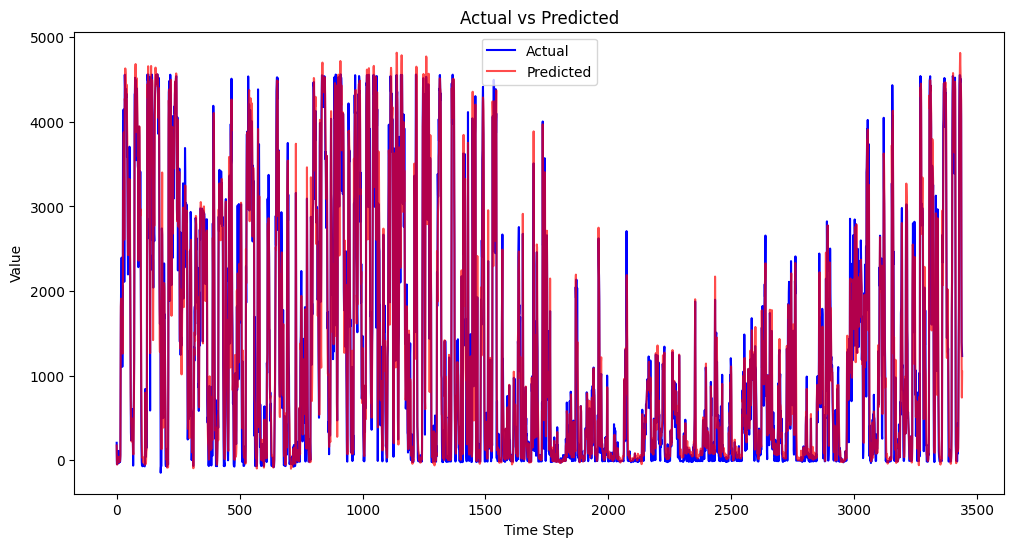

In [21]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(final['real'].values, label='Actual', color='blue')
plt.plot(final['pred'].values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()